In [1]:
import pathlib
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import tarfile
from os import path
from tensorflow.keras import layers
from tensorflow import keras
import python_splitter
import shutil
from tensorflow.keras.models import load_model

In [2]:
 tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
if not path.isdir('dataset'):
    data_dir = tf.keras.utils.get_file(
        "dataset.tar",
        "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar",
        extract=False)
    with tarfile.open(data_dir, 'r') as tar_ref:
        tar_ref.extractall(path='/data/dataset/')
    print('Dataset installé')
else:
    print('Dataset déja installé')


Dataset déja installé


python_splitter.split_from_folder a un bug et inverse le répertoire de test et de val donc il faut inverser les valeurs

In [4]:
if path.isdir('Train_Test_Folder'):
    shutil.rmtree("Train_Test_Folder")
python_splitter.split_from_folder("/data/dataset/Images", train = 0.7, test = 0.25)

✅Checking SOURCE directory...
0.7 0 0.25
✅Checking percentage validation...
✅Making required directories...
✅Shuffling data...
✅Getting ready for copying files...

-------------Successfully splitted !!!--------------- 


Found 14355 files belonging to 120 classes.
Found 1077 files belonging to 120 classes.
Found 5148 files belonging to 120 classes.


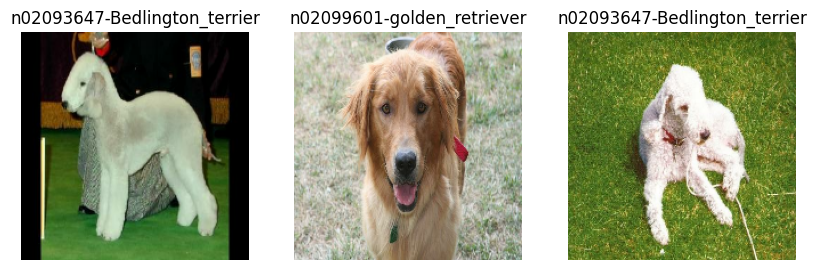

In [5]:
batch_size = 30
img_height = 200
img_width = 200

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    pathlib.Path('Train_Test_Folder/train'),
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    pathlib.Path('Train_Test_Folder/test'),
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

validate_data = tf.keras.preprocessing.image_dataset_from_directory(
    pathlib.Path('Train_Test_Folder/val'),
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

class_names = train_data.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

J'augmente mon nombre de donnée en appliquant une rotation

In [6]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])


In [7]:
vgg = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet");
vgg.trainable = False;

In [8]:
num_classes = 120

model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(128,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'],)

logdir="logs"

tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1, write_images=logdir)

model.fit( 
    train_data,
  validation_data=validate_data,
  epochs=30,
  callbacks=[tensorboard_callback]
)
     

Epoch 1/30
479/479 [==============================] - 36s 68ms/step - loss: 4.7409 - accuracy: 0.0145 - val_loss: 4.6169 - val_accuracy: 0.0282
Epoch 2/30
479/479 [==============================] - 32s 67ms/step - loss: 4.4966 - accuracy: 0.0375 - val_loss: 4.4984 - val_accuracy: 0.0402
Epoch 3/30
479/479 [==============================] - 32s 66ms/step - loss: 4.2653 - accuracy: 0.0651 - val_loss: 4.5121 - val_accuracy: 0.0441
Epoch 4/30
479/479 [==============================] - 32s 66ms/step - loss: 4.0001 - accuracy: 0.1000 - val_loss: 4.5773 - val_accuracy: 0.0474
Epoch 5/30
479/479 [==============================] - 32s 66ms/step - loss: 3.7218 - accuracy: 0.1464 - val_loss: 4.9429 - val_accuracy: 0.0462
Epoch 6/30
479/479 [==============================] - 32s 66ms/step - loss: 3.4372 - accuracy: 0.1976 - val_loss: 5.2671 - val_accuracy: 0.0474
Epoch 7/30
479/479 [==============================] - 32s 67ms/step - loss: 3.1648 - accuracy: 0.2474 - val_loss: 5.8179 - val_accuracy:

In [9]:
model.save('MLP.h5')

In [12]:
loss0, accuracy0 = model.evaluate(test_data)

36/36 [==============================] - 1s 24ms/step - loss: 21.5411 - accuracy: 0.0409
